## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

mkdir: cannot create directory ‘./ckpts’: File exists


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 100
CROP_SIZE = 256
if CROP_SIZE == 512:
    BATCH_SIZE = 8
if CROP_SIZE == 768:
    BATCH_SIZE = 16
else:
    BATCH_SIZE = 32
TRAIN_STRIDE = 256
RESNET_DEPTH = 34 # 18, 34

N_TRAIN = 1

FOLD = 1

if FOLD == 1:
    TRAIN_FRAGMENTS = ["2", "3"]
    TEST_FRAGMENT = "1"
elif FOLD == 2:
    TRAIN_FRAGMENTS = ["1", "3"]
    TEST_FRAGMENT = "2"
elif FOLD == 3:
    TRAIN_FRAGMENTS = ["1", "2"]
    TEST_FRAGMENT = "3"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 16:40]
!rm fragment_crop.mp4
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

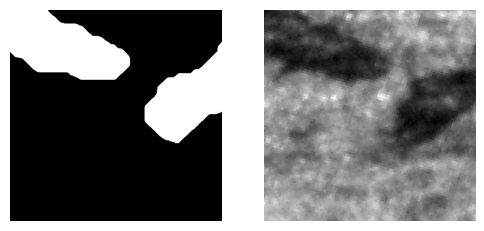

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4083

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in tqdm(range(0, H-CROP_SIZE+1, TRAIN_STRIDE)):
                for x in range(0, W-CROP_SIZE+1, TRAIN_STRIDE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface>0.01) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=8, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                A.Normalize(
                    mean= [0] * 20,
                    std= [1] * 20
                ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        
        z_offset = np.random.randint(-6, 3)
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, 20+z_offset:40+z_offset]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        frag_crop = frag_crop/255.0
        
        
        # implement cutmix. 
        if np.random.uniform(0, 1) < 0.5:
            # get a random int between 0 and len(self.xys)
            random_index = np.random.randint(0, len(self.xys))
            fragment, x1, y1, W, H = self.xys[random_index]
            
            x2 = x1 + CROP_SIZE
            y2 = y1 + CROP_SIZE
            

            frag_crop_2 = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, 16:40]            
            mask_crop_2 = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
            frag_crop_2 = frag_crop/255.0
            
            
            
            rand_wh = np.random.randint(32, CROP_SIZE//2)
            rand_position_start_y = np.random.randint(0, CROP_SIZE-rand_wh)
            rand_position_start_x = np.random.randint(0, CROP_SIZE-rand_wh)
            rand_weight = np.random.uniform(0.2, 0.8)
            
            frag_crop[rand_position_start_y:rand_position_start_y+rand_wh, 
                      rand_position_start_x:rand_position_start_x+rand_wh, 
                      :] = frag_crop_2[rand_position_start_y:rand_position_start_y+rand_wh, 
                                       rand_position_start_x:rand_position_start_x+rand_wh, :] * rand_weight \
                        + frag_crop[rand_position_start_y:rand_position_start_y+rand_wh, 
                                    rand_position_start_x:rand_position_start_x+rand_wh, :] * (1-rand_weight)
            
            # same for the mask
            mask_crop[rand_position_start_y:rand_position_start_y+rand_wh,
                        rand_position_start_x:rand_position_start_x+rand_wh] = mask_crop_2[rand_position_start_y:rand_position_start_y+rand_wh,
                                                                                            rand_position_start_x:rand_position_start_x+rand_wh] * rand_weight \
                        + mask_crop[rand_position_start_y:rand_position_start_y+rand_wh,
                                    rand_position_start_x:rand_position_start_x+rand_wh] * (1-rand_weight)
                        
            
            
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float()
        
        
        
        # # add noise to the frag_crop
        # noise_sigma = 0.5 # np.random.uniform(0.0, 0.8)
        # noise_vector = torch.abs(torch.randn_like(mask_crop)) * noise_sigma
                
        # # frag_crop += noise_vector
        # z_start = np.random.randint(0, 15)
        # # frag_crop[z_start:z_start+10, :, :] += noise_vector
        # frag_crop[z_start, :, :] += noise_vector * mask_crop
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
        self.valid_aug_list = [
                A.Normalize(
                    mean= [0] * 20,
                    std= [1] * 20
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.valid_aug_list)
        
        
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        # z1, z2 = Z_START, Z_START+Z_DIMS
        
        # random number between -6 and 0
        z_offset = 0 # np.random.randint(-3, 3)
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, 20+z_offset:40+z_offset]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/255.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float()
        
        
        # # add noise to the frag_crop
        # noise_sigma = np.random.uniform(0.0, 0.8)
        # noise_vector = torch.abs(torch.randn_like(mask_crop)) * noise_sigma
        # # frag_crop += noise_vector
        # z_start = np.random.randint(0, 15)
        # # frag_crop[z_start:z_start+10, :, :] += noise_vector
        # frag_crop[z_start, :, :] += noise_vector * mask_crop
        
        
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)
print("n_train", n_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

100%|██████████| 28/28 [00:00<00:00, 37.11it/s]

n_train 243


In [12]:
i = random.randint(0, len(dataset_train))
img, mask = dataset_train[i][0], dataset_train[i][1]
img.min(), img.max(), mask.shape, mask.min(), mask.max()

(tensor(0.), tensor(1.0078), torch.Size([512, 512]), tensor(0.), tensor(1.))

In [13]:
i = random.randint(0, len(dataset_valid))
img = dataset_valid[i][0]
img.min(), img.max()

(tensor(0.), tensor(1.0078))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=RESNET_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
if RESNET_DEPTH < 50:
    model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

In [16]:
# import segmentation_models_pytorch as smp


# model = smp.create_model(
#     "unet",
#     encoder_name="resnet34",
#     in_channels=20,
#     classes=1, 
#     encoder_weights=None,
# ).cuda()

In [17]:
# load weights from "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/exp-1-reproduce-training-with-augm-bce-dice-loss-size-256-denoising-pretraining/ckpts/resnet34_3d_seg_epoch_15.pt"
# model.load_state_dict(torch.load("./ckpts/resnet34_3d_seg_best.pt"))

In [18]:
x = torch.randn(5, 1, 20, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [19]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [20]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 
#                                               start_factor=0.01,
#                                               end_factor=1,
#                                               total_iters=10)

In [21]:
import segmentation_models_pytorch as smp

DiceLoss = smp.losses.DiceLoss(mode='binary', from_logits=True)
BCELoss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.02)


def criterion(y_pred, y_true):
    
    # Mean squared error
    # return nn.MSELoss()(y_pred, y_true)
    
    
    # return DiceLoss(y_pred, y_true)
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [22]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [23]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [24]:
from sklearn.metrics import accuracy_score
fbeta_best = 0.0


for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    # pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    pbar_train = tqdm(pbar_train, total=N_TRAIN, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks.squeeze(), masks)
            # loss = criterion(pred_masks.squeeze(), noise_vector)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
        if i >= N_TRAIN:
            break

    out = {}
    out['epoch'] = epoch
    out['lr'] = scheduler.get_last_lr()[0]
    out['loss_train'] = mloss_train / (i + 1)
    
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks.squeeze(), masks).item()
            pred_masks = torch.sigmoid(pred_masks)
            # mloss_val += criterion(pred_masks.squeeze(), noise_vector).item()
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        
    
    out['loss_val'] = mloss_val / (i + 1)
    
    
    
    for threshold in np.arange(0.2, 1.00, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        out[f"fbeta_{threshold:.2f}"] = fbeta.item()
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            !rm ./ckpts/resnet34_3d_seg_best*
            torch.save(model.state_dict(), f"./ckpts/resnet34_3d_seg_best_{threshold:.3f}.pt")
    
    # calculate accuracy
    
    accuracy = accuracy_score(gt_mask.flatten().cpu().numpy(), (final_pred_mask > 0.5).flatten().cpu().numpy())
    out['accuracy'] = accuracy
    
    df_out = pd.DataFrame(out, index=[0])
    
    if epoch == 1:
        !rm resnet34_3d_seg-round-2.csv
        df_out.to_csv("resnet34_3d_seg-round-2.csv", index=False)
    else:
        # first read the old csv file
        df_old = pd.read_csv("resnet34_3d_seg-round-2.csv")
        # append the new row to it
        df_new = pd.concat([df_old, df_out], ignore_index=True)
        # save the new csv file
        df_new.to_csv("resnet34_3d_seg-round-2.csv", index=False)
        
    # torch.save(model.state_dict(), f"./ckpts/resnet34_3d_seg_epoch_{epoch}.pt")


    # if epoch == 30:
    #     break

    print()

Epoch 1/100  Mem : 20.7GB  LR : 4.00E-06  Loss: 0.7166:  45%|████▌     | 29/64 [00:20<00:24,  1.40it/s]


KeyboardInterrupt: 